# Comparing different clustering algorithms

## toy datasets

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

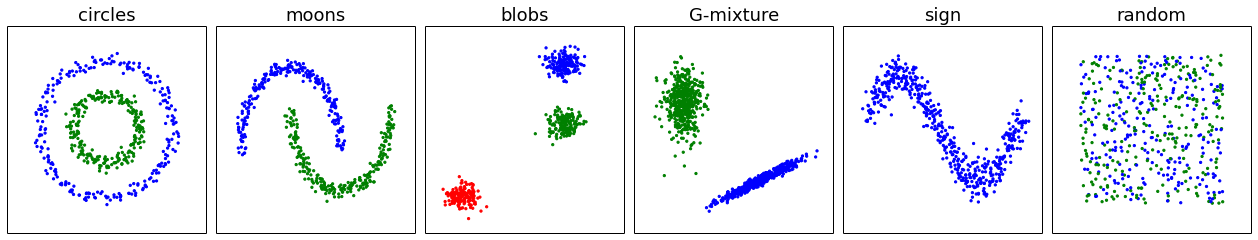

In [3]:
from sklearn import datasets

n_samples = 500

noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
gaussian_mixtures = np.r_[np.dot(np.random.randn(n_samples, 2), np.array([[0., -0.1], [1.7, .4]])),
        .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])], np.append(np.zeros(n_samples), np.ones(n_samples))
_ = datasets.make_regression(n_samples=n_samples, n_features=1, noise=2.0)
X = np.zeros((n_samples, 2))
step = 2 * np.pi / n_samples
for i in xrange(X.shape[0]):
    x = i * step - 6
    X[i, 0] = x + np.random.normal(0, 0.1)
    X[i, 1] = 3 * (np.sin(x) + np.random.normal(0, .2))
noisy_sign = X, np.zeros(n_samples)

no_structure = np.random.rand(n_samples, 2), np.random.randint(2, size=n_samples)

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

dataset_list = [
    {'name':'circles',   'data':noisy_circles},
    {'name':'moons',     'data':noisy_moons},
    {'name':'blobs',     'data':blobs},
    {'name':'G-mixture', 'data':gaussian_mixtures},
    {'name':'sign',      'data':noisy_sign},
    {'name':'random',    'data':no_structure},
]

plt.figure(figsize=(len(dataset_list) * 3, 3))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

for i, dataset in enumerate(dataset_list):
    X, y = dataset['data']
    y = y.astype(np.int)
    
    plt.subplot(1, len(dataset_list), i+1)
    plt.scatter(X[:, 0], X[:, 1], color=colors[y].tolist(), s=5)
    
    plt.title(dataset['name'], size=18)
    plt.xticks(())
    plt.yticks(())


In [4]:
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from scipy import linalg

def do_cluster(dataset_list, algorithm_list):
    plt.figure(figsize=(len(dataset_list) * 3, len(algorithm_list) * 3))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

    for i, dataset in enumerate(dataset_list):
        X, y = dataset['data']
        X = StandardScaler().fit_transform(X)
    
        bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)
        connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
        connectivity = 0.5 * (connectivity + connectivity.T)
    
        for j, algorithm in enumerate(algorithm_list):
            c = algorithm['algorithm']
            if 'bandwidth' in c.get_params().keys():
                c.set_params(bandwidth=bandwidth)
            if 'connectivity' in c.get_params().keys():
                c.set_params(connectivity=connectivity)

            c.fit(X)
            if hasattr(c, 'labels_'):
                y_pred = c.labels_.astype(np.int)
            else:
                y_pred = c.predict(X)

            splot = plt.subplot(len(algorithm_list), len(dataset_list), j*len(dataset_list)+i+1)
            plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=5)
            if hasattr(c, 'cluster_centers_'):
                centers = c.cluster_centers_
                center_colors = colors[:len(centers)]
                plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
            if hasattr(c, 'means_'):
                for k, (mean, covar, color) in enumerate(zip(c.means_, c._get_covars(), colors[:len(c.means_)])):
                    if not np.any(y_pred == k):
                        continue
                    v, w = linalg.eigh(covar)
                    u = w[0] / linalg.norm(w[0])

                    angle = np.arctan(u[1] / u[0])
                    angle = 180 * angle / np.pi  # convert to degrees
                    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
                    ell.set_clip_box(splot.bbox)
                    ell.set_alpha(0.5)
                    splot.add_artist(ell)

            if j == 0:
                plt.title(dataset['name'], size=18)
            plt.xticks(())
            plt.yticks(())
            plt.text(.99, .01, algorithm['name'], transform=plt.gca().transAxes, size=15, horizontalalignment='right')

## clustering algorithm (with number of clusters)

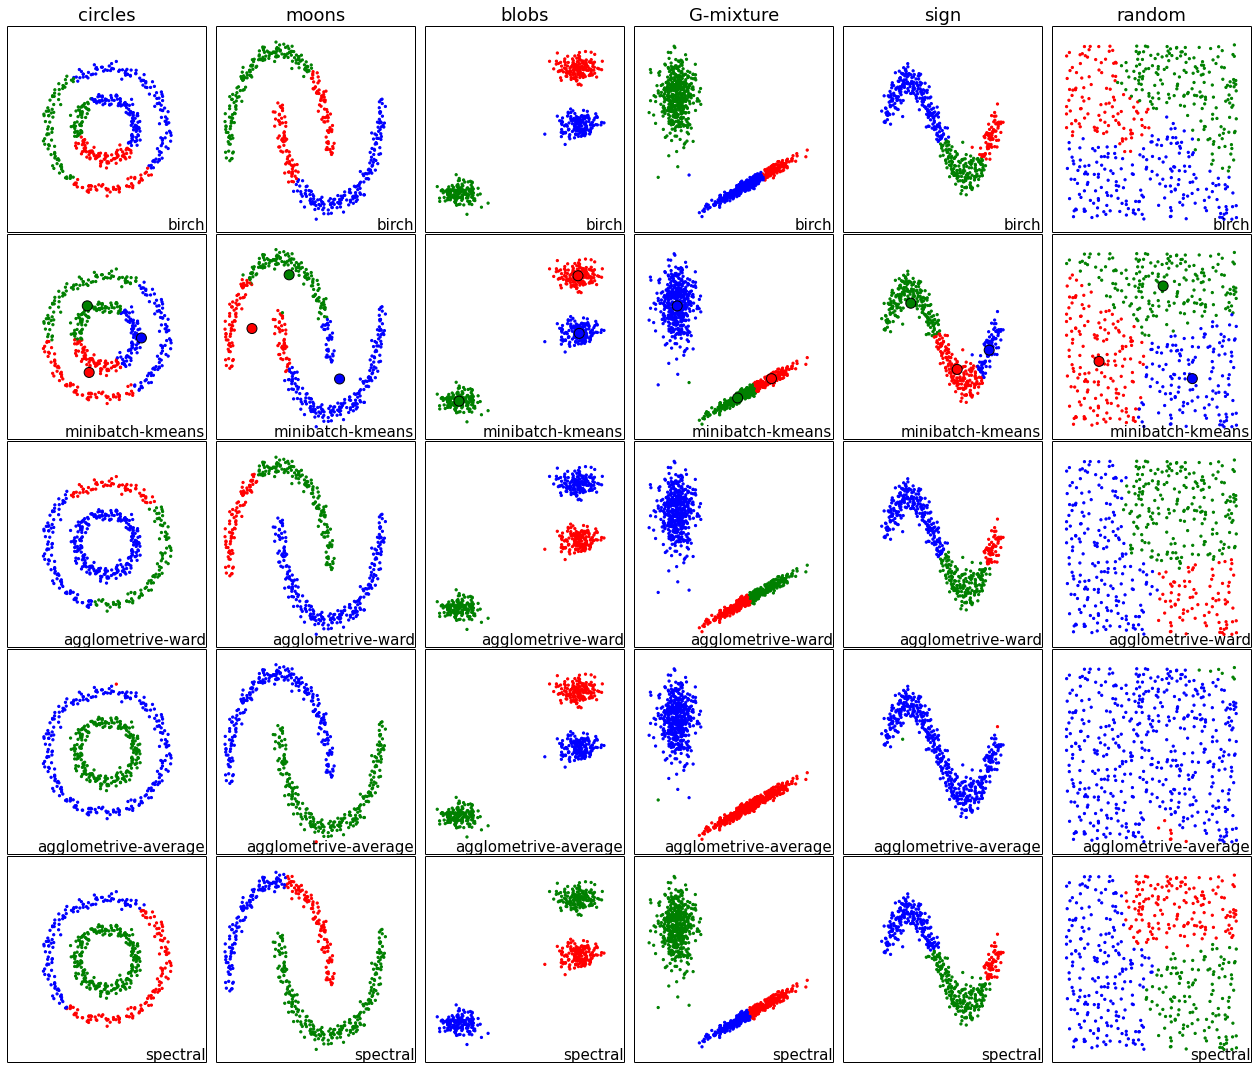

In [6]:
from sklearn import cluster

n_clusters=3
algorithm_list = [
    {'name':'birch',                 'algorithm':cluster.Birch(n_clusters=n_clusters)},
    {'name':'minibatch-kmeans',      'algorithm':cluster.MiniBatchKMeans(n_clusters=n_clusters)},
    {'name':'agglometrive-ward',     'algorithm':cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')},
    {'name':'agglometrive-average',  'algorithm':cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage="average", affinity="cityblock")},
    {'name':'spectral',              'algorithm':cluster.SpectralClustering(n_clusters=n_clusters, eigen_solver='arpack', affinity="nearest_neighbors")},
]

do_cluster(dataset_list, algorithm_list)

## clustering algorithm (without number of clusters)

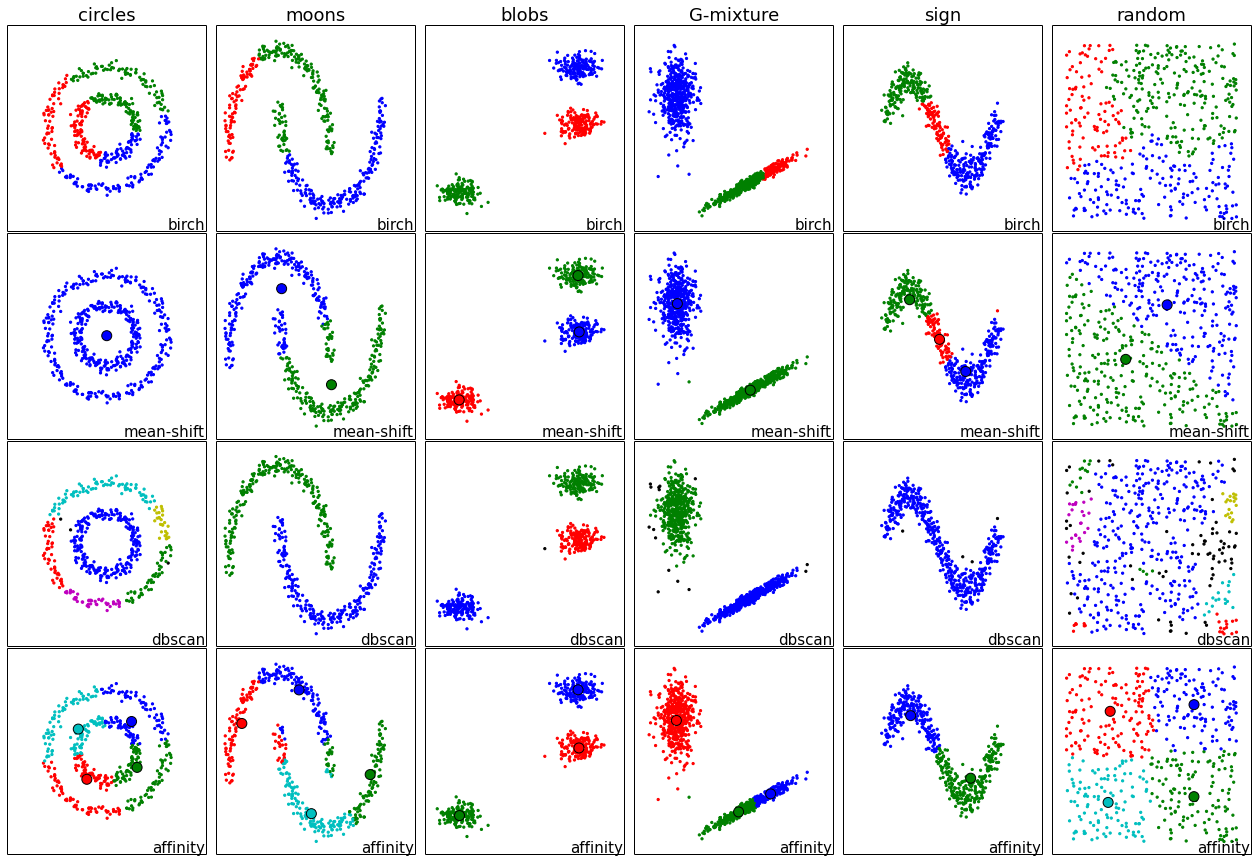

In [7]:
from sklearn import cluster
algorithm_list = [
    {'name':'birch',                 'algorithm':cluster.Birch(threshold=0.05, branching_factor=5)},
    {'name':'mean-shift',            'algorithm':cluster.MeanShift(bin_seeding=True)},
    {'name':'dbscan',                'algorithm':cluster.DBSCAN(eps=.2)},
    {'name':'affinity',              'algorithm':cluster.AffinityPropagation(damping=.85, preference=-100)},
]

do_cluster(dataset_list, algorithm_list)

## clustering algorithm (Gaussian Mixture Model)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in double_scalars


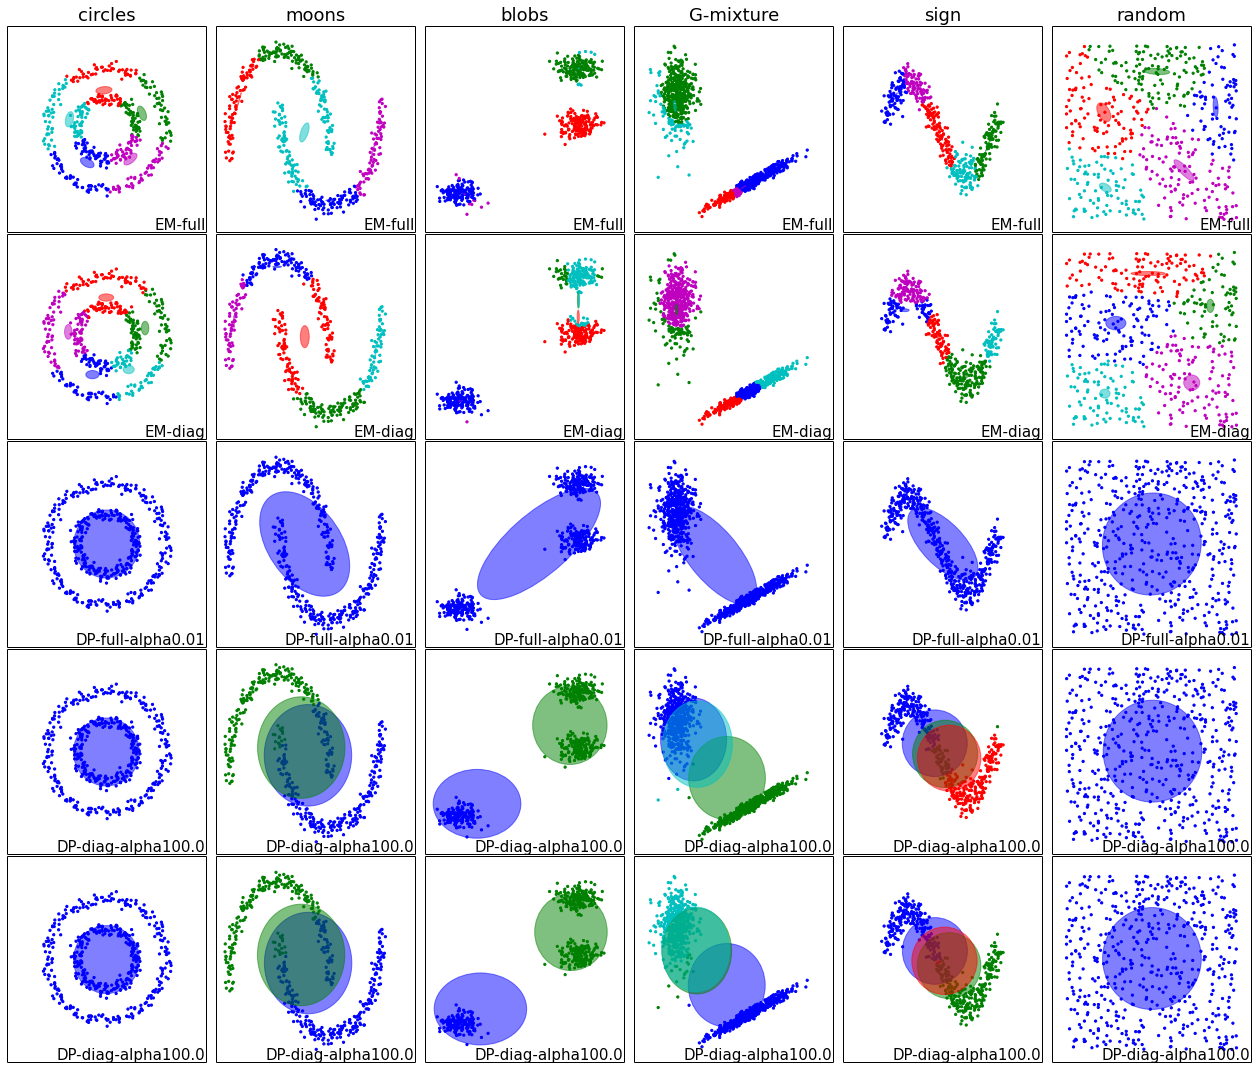

In [8]:
from sklearn import mixture

algorithm_list = [
    {'name':'EM-full',            'algorithm':mixture.GMM(  n_components=5, covariance_type='full', n_iter=100)},
    {'name':'EM-diag',            'algorithm':mixture.GMM(  n_components=5, covariance_type='diag', n_iter=100)},
    {'name':'DP-full-alpha0.01',  'algorithm':mixture.DPGMM(n_components=5, covariance_type='full', alpha=0.01,  n_iter=100)},
    {'name':'DP-diag-alpha100.0', 'algorithm':mixture.DPGMM(n_components=5, covariance_type='diag', alpha=100.0, n_iter=100)},
    {'name':'DP-diag-alpha100.0', 'algorithm':mixture.DPGMM(n_components=5, covariance_type='diag', alpha=100.0, n_iter=100)},
]

do_cluster(dataset_list, algorithm_list)

## hierarchy clustering algorithm

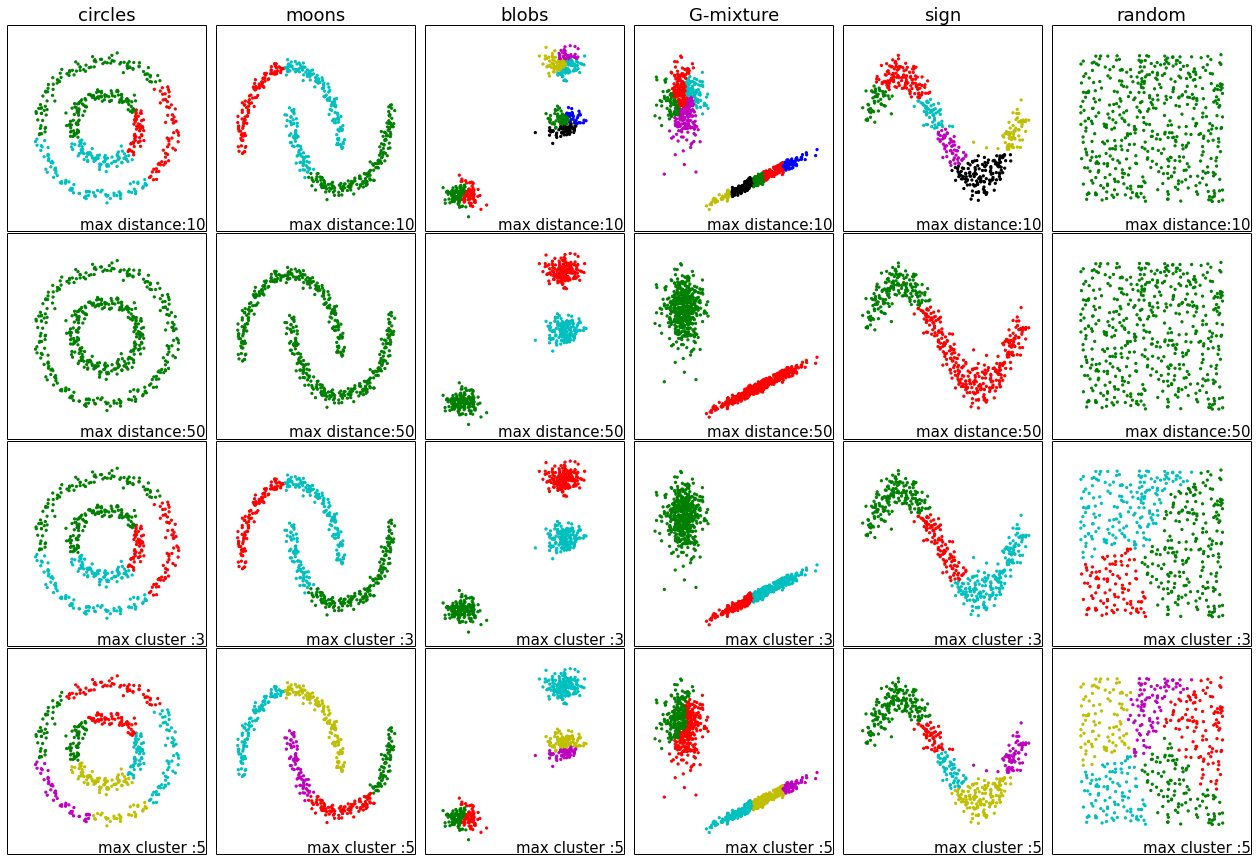

In [9]:
from scipy.cluster import hierarchy


algorithm_list = [
    {'name':'max distance:10',  'params':{'t':10,  'criterion':'distance'}},
    {'name':'max distance:50',  'params':{'t':50,  'criterion':'distance'}},
    {'name':'max cluster :3',   'params':{'t':3,   'criterion':'maxclust'}},
    {'name':'max cluster :5',   'params':{'t':5,   'criterion':'maxclust'}},
]

plt.figure(figsize=(len(dataset_list) * 3, len(algorithm_list) * 3))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

for i, dataset in enumerate(dataset_list):
    X, y = dataset['data']
    Z = hierarchy.linkage(X, 'ward')
    
    for j, algorithm in enumerate(algorithm_list):
        y_pred = hierarchy.fcluster(Z, algorithm['params']['t'], criterion=algorithm['params']['criterion'])

        splot = plt.subplot(len(algorithm_list), len(dataset_list), j*len(dataset_list)+i+1)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=5)

        if j == 0:
            plt.title(dataset['name'], size=18)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, algorithm['name'], transform=plt.gca().transAxes, size=15, horizontalalignment='right')